# Introduction

This notebook introduces how to use the topicmodels module for implementing Latent Dirichlet Allocation using the collapsed Gibbs sampling algorithm of Griffiths and Steyvers (2004).  The module contains three classes: one for processing raw text, another for implementing LDA, and another for querying.  This tutorial will go through the main features of each, for full details see the documented source code.

To illustrate LDA, the tutorial uses text data from State of the Union Addresses at the paragraph level.  These are available for download from http://www.presidency.ucsb.edu/sou.php.  They are contained in the tab-separated text file speech_data_extend.txt distributed with this tutorial.

To interact with this data, we begin by importing some libraries that are not strictly speaking necessary for using topicmodels.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

To begin, we read in the data, specifying the encoding of the text data.

In [2]:
data = pd.read_table("speech_data_extend.txt",encoding="utf-8")

The data object is called a pandas DataFrame, and is similar to a Data Frame in R.  One can see the data has three fields.

In [3]:
data.columns

Index([u'president', u'speech', u'year'], dtype='object')

For the tutorial we focus on State of the Union addresses made since the television era, which began in 1947.

In [4]:
data = data[data.year >= 1947]
len(data) # The number of documents (paragraphs of State of the Union Addresses) in the dataset

9488

# Cleaning Raw Text Data

We now import topicmodels, the module used in most of the analysis.

In [5]:
import topicmodels

Before implementing a topic model, it is important to pre-process the data.  The first class in the topicmodels module is called RawDocs and facilitates this pre-processing.  We are going to pass this class the text data contained in the DataFrame along with a list of stopwords specified by "long".  Stopwords are common words in English that tend to appear in all text, and so are not helpful in describing content.  There is no definitive list of stopwords, and another option we describe below is to let the data itself reveal which words are useful for discriminating among documents.  The list of words comes from http://snowball.tartarus.org/algorithms/english/stop.txt, but one need not use all of them.  In Hansen, McMahon, and Prat (2014), for example, we use just a subset of these, which you can use by specifying "short" instead of "long".  (You can view the stopwords by typing docsobj.stopwords into the interpreter).

In [6]:
docsobj = topicmodels.RawDocs(data.speech, "long")

Rather than passing the text as a DataFrame column, one can also pass a text file, in which case each new line will be read as a separate document.

docsobj is now an object with several attributes.  The most important is its tokens attribute.  This is the outcome of taking each raw document, converting each contraction into its underlying words (e.g. "don't" into "do not"), coverting it into lowercase, and breaking it into its underlying linguistic elements (words, numbers, punctuation, etc.).  To illustrate, compare the fourth paragraph in the 1947 State of the Union Address as a raw document and after tokenization.

In [7]:
print(data.speech.values[3]) # fourth paragraph (note that Python uses 0-indexing)
print(docsobj.tokens[3])

I come also to welcome you as you take up your duties and to discuss with you the manner in which you and I should fulfill our obligations to the American people during the next 2 years. 
[u'i', u'come', u'also', u'to', u'welcome', u'you', u'as', u'you', u'take', u'up', u'your', u'duties', u'and', u'to', u'discuss', u'with', u'you', u'the', u'manner', u'in', u'which', u'you', u'and', u'i', u'should', u'fulfill', u'our', u'obligations', u'to', u'the', u'american', u'people', u'during', u'the', u'next', u'2', u'years', u'.']


At this point, all tokens are in the dataset, which can be useful for some purposes.  For example, one might want to count the number of question marks in each speech.  For implementing LDA, though, one generally wishes to focus on words.  docsobj has a method to clean tokens.  This will remove all non-alphanumeric tokens, and, by default, all numeric tokens as well (to keep numeric tokens, pass False as the second argument in parentheses).  The number passed as an argument removes all tokens whose length is less that - this can be useful if some symbols in the data like copyright signs trascribed as a single 'c' that the user would like to remove, in which case one would pass 1.  In this case, we pass 1 for illustration.

In [8]:
docsobj.token_clean(1)

In [9]:
print(docsobj.tokens[3])

[u'come', u'also', u'to', u'welcome', u'you', u'as', u'you', u'take', u'up', u'your', u'duties', u'and', u'to', u'discuss', u'with', u'you', u'the', u'manner', u'in', u'which', u'you', u'and', u'should', u'fulfill', u'our', u'obligations', u'to', u'the', u'american', u'people', u'during', u'the', u'next', u'years']


Next, we remove the stopwords we passed when creating docsobj.  Here we pass "tokens" as an argument to specify that the stopwords should be removed from docsobj.tokens.  The other option would be to pass "stems", which we discuss below.  Notice by how much we have reduced the size of the document by removing stopwords!

In [10]:
docsobj.stopword_remove("tokens")
print(docsobj.tokens[3])

[u'come', u'welcome', u'duties', u'discuss', u'manner', u'fulfill', u'obligations', u'american', u'people', u'next', u'years']


The next step is to attempt to group together words that are grammatically different but themeatically identical.  For example, the document above has the token "obligations" but another may have "obligation" and yet another "oblige."  Ultimately these three words denote the same concept, and so we might want them to share the same symbol.  One way to achieve this is through stemming, a process whereby words are transformed through a deterministic algorithm to a base form.  One popular stemmer is the Porter stemmer, which docsobj applies (via its implementation in Python's Natural Language Toolkit).  This creates a new stems attribute.

In [11]:
docsobj.stem()
print(docsobj.stems[3])
docsobj.stopword_remove("stems")

[u'come', u'welcom', u'duti', u'discuss', u'manner', u'fulfil', u'oblig', u'american', u'peopl', u'next', u'year']


Notice that the outcome of stemming need not be an English word.  These stems are the data on which we will run the topic model below.  We make an additional call to remove stopwords from stems, since the stemmed forms of tokens not in the stopword list may themselves be in the stopword list.

The final step in pre-processing is to drop remaining words that are not useful for identifying content.  We have already dropped standard stopwords, but there may also be data-dependent common words.  For example, in data from Supreme Court proceedings, "justice" might be treated as a stopword.  Also, words that appear just once or twice in the collection are not informative of content either.  Ideally, one would like a measure of informativeness that both punishes common words in the data, and rare words.  One such option is to give each stem a tf-idf (term frequency - inverse document frequency) score.  This is standard in the language processing literature, so we omit details here.

In [12]:
docsobj.term_rank("stems")

This call produces two .csv files in the working directory, df_ranking.csv and tfidf_ranking.csv.  df_ranking.csv ranks each stem according to its document frequency, or the number of documents it appears in.  tfidf_ranking.csv ranks each stem accroding to the tf-idf measure, according to which highly informative words are those that appear frequently in the entire dataset, but in relatively few documents.  Stems with the highest scores include "gun", "iraq", and "immigr".

At this stage, the user can decide how many stems to drop based on either the df or tf-idf scores.  The first argument to rank_remove specifies the ranking method to use ("df" or "tfidf"), the second whether to drop from "tokens" or "stems" (since we formed the rankings based on stems above, we should specify stems), and finally the value to use for the cutoff for dropping stems.  One might instead prefer to provide a number $n$ such that all stems with a tf-idf value less than or equal to the $n$th ranked stem are then dropped, which we illustrate below.  One can determine the cutoff from exploring the csv files, but here we plot the ranking in Python, which indicates a reasonable cutoff is 5000.  (When using df rather than tfidf, substitute docsobj.df_ranking).

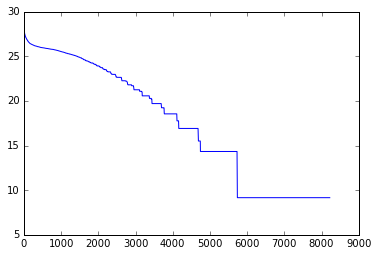

In [13]:
plt.plot([x[1] for x in docsobj.tfidf_ranking])

In [14]:
docsobj.rank_remove("tfidf","stems",docsobj.tfidf_ranking[5000][1])
all_stems = [s for d in docsobj.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 4742
number of total stems = 250000


After pre-processing, we have 4742 unique stems, and 250000 total stems.  We now proceed to estimate a topic model on them.

# Estimating a Topic Model

The first step in estimation is to initialize a model via topicmodels' LDA class.  We will pass docsobj.stems as the set of documents, and we also need to decide on a number of topics.  Here we choose 30 topics. 

In [15]:
ldaobj = topicmodels.LDA.LDAGibbs(docsobj.stems,30)

There are three main parameters in LDA, the number of topics, and the two hyperparameters of the Dirichlet priors.  topicmodels.LDA follows the advice of Griffiths and Steyvers (2004) and sets the hyperparameter of the Dirichlet prior on topics to $200/V$, where $V$ is the number of unique vocabulary elements, and the hyperparameter of the Dirichlet prior on document-topic distributions to $50/K$, where $K$ is the number of topics.

In [16]:
print(ldaobj.K) # number of topic, user defined.
print(ldaobj.alpha) # hyperparameter for document-topic distribution, automatically defined
print(ldaobj.beta) # hyperparameter for topics, automatically defined

30
1.66666666667
0.0421762969211


Should users wish to define their own priors, they can do so by calling ldaobj.set_prior(alpha,beta).  

Another quantity set automatically by topicmodels.LDA is a random allocation of stems to topic assignments.  It is a 250000-dimensional vector of integers in $\{0,\ldots,29\}$.  Should the user wish to define another seed, call ldaobj.set_seed.

In [17]:
print(ldaobj.topic_seed[:10])
print(ldaobj.topic_seed.shape)

[22  8 17  7 17  8  4 27 12 15]
(250000,)


Now that we have initialized our topic model, we are ready to sample.  To sample, we pass three parameters.  The first is the number of iterations we want the chain to burn in before beginning to sample.  The second is a thinning interval, the number of iterations to let the chain run between samples.  Allowing for a thinning interval reduces autocorrelation between samples.  The third is the number of samples to take.  So, for example, if the user passes (1000,50,20) the following will happen.  First, the chain will run for 1,000 iterations.  Then 20 samples will be taken corresponding to the $\{1050,1100\ldots,1950,2000\}$ iterations for a total of 2000 iterations overall.

In order not to waste time in the tutorial, we start with a relatively short chain with no burnin, a thinning interval of 50, and 10 samples, for a total of 500 iterations.

In [18]:
ldaobj.sample(0,50,10)

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

Because we allowed no burn in and started sampling straight away, one would imagine the initial draws were poor in terms of describing topics.  A formalization of this idea is to compute the perplexity of each of the samples.  Perplexity is a common goodness-of-fit meausure in natural language processing and information theory literature that describes how well a probability model explains data.  Lower values indicate better goodness-of-fit.  Calling ldaobj.perplexity() returns the perplexity of each sample.

In [19]:
ldaobj.perplexity()

array([910.00942281, 874.09497579, 862.04496391, 852.09503063,
       847.52895528, 843.21069781, 842.30736504, 840.07617437,
       840.15844958, 838.29737893])

Just as we suspected, the first sample has a much higher perplexity than the last.  Moreover, it might be that if we had kept sampling the chain, we could get even lower perplexity.  Once we call ldaobj.sample the first time, all further calls extend the existing chain by default rather than start from scratch.  So let's draw another ten samples.

In [20]:
ldaobj.sample(0,50,10)

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

In [21]:
ldaobj.perplexity()

array([910.00942281, 874.09497579, 862.04496391, 852.09503063,
       847.52895528, 843.21069781, 842.30736504, 840.07617437,
       840.15844958, 838.29737893, 837.77127923, 838.24312563,
       835.7131597 , 834.27288412, 835.88357615, 834.14504198,
       834.5741682 , 834.92096362, 836.03689584, 834.48549032])

Indeed, the topic model has improved, and may yet improve more with further sampling, but at this point we will stop to continue with the tutorial.  (In research applications, one would normally apply some convergence criterion to determine the stopping point.)  Ideally we'd like to throw away the initial samples and only keep the last ones.  ldaobj.samples_keep(n) keeps the last n samples of the chain (users can also pass a list of numbers corresponding to the indices they'd like to keep - remember that Python uses 0-indexing).  We will keep the last four samples.

In [22]:
ldaobj.samples_keep(4)

So far we have only been sampling topic assignments for all the words in the dataset.  What we really care about are the topics and the distribution of topics in each document.  ldaobj has been carrying these around for us while we have been sampling.  ldaobj.tt are the esitmated topics, and ldaobj.dt are the estimated document-topic distributions.

In [23]:
print(ldaobj.tt.shape)
print(ldaobj.dt.shape)

(4742, 30, 4)
(9488, 30, 4)


The estimated topics are represented by $4742 \times 30$ matrices whose columns sum to one, one for each sample, while the estimated distributions of topics within each document are represented by $9488 \times 30$ matrices whose rows sum to one.  To get an idea of the topics that have been estimated, and whether they make sense, ldaobj.topic_content(n) produces topic_description.csv in the working directory.  Its rows contain the first n stems in each topic ranked according their probability, using the final stored sample.  It's a good idea to check the topics are "reasonable" before proceeding with any analysis.

In [24]:
ldaobj.topic_content(20)

Most economics researchers will probably be most interested initially in the distributions of topics within each document.  To generate these, one should average the matrices in ldaobj.dt.  Here we have only taken four samples for purposes of illustration, but in actual research one should ideally take as many as is computationally feasible.  ldaobj has a convenience method for doing this average, which will both return it as well as, by default, write it to dt.csv in the working directory (to disable printing, pass False to the method).

In [25]:
dt = ldaobj.dt_avg()

One might also be interested in the average topics themselves, in which case there is a similar convenience function available that writes tt.csv to the working directory by default.  Each unique stem in the data is associated to a number corresponding to rows of the topic matrices.  Therefore, in most cases one will probably want to print out this key too, available as ldaobj.dict_print.

In [26]:
tt = ldaobj.tt_avg()
ldaobj.dict_print()

One might also want to replace the speech field in the original dataset with the estimated topics in order to have a ready-to-go dataset for regression or other econometric analysis.  The following code builds this dataset, and also writes it to file.

In [27]:
data = data.drop('speech',1)
for i in xrange(ldaobj.K): data['T' + str(i)] = dt[:,i]
data.to_csv("final_output.csv",index=False)

If one wishes to analyze some function of the estimated document-topic distributions, this function should be computed for each separate sample and then averaged.  Since the relevant functions are context-specific, topicmodels.LDA does not provide them, but it can be easily extended to accomodate this.

# Querying Using Estimated Topics

After estimating a topic model, one is often interested in estimating the distribution of topics for documents not included in estimation.  In this case, one option is to $\textit{query}$ those documents by holding fixed the topics estimated from LDA, and only estimating the distribution of topics for the out-of-sample documents.  The topicmodels module also provides a class for such querying, which this section introduces.

We will apply querying to the corpus of entire State of the Union Addresses since 1947 (recall that we estimated topics on the level of the paragraph within each speech).  In terms of estimating topics, the paragraph level is preferable to the speech level since individual paragraphs are more likely to be based around a single theme.  But, in terms of econometric work, the entire speech is a more natural unit of analysis.  At the same time, there is no general way of "adding up" probability distribution at the paragraph level in order to arrive at a speech-level distribution.  Hence the need for querying, which allows us to estimate the speech-level distributions.  (Extra credit: after the tutorial, estimate LDA on the entire speech level, and judge for yourself how the topics compare to those estimated at the paragraph level).

The Query class is initialized in much the same way as LDA, but takes two additional objects: a 3-D array of estimated topics (number of tokens in the estimated topics $\times$ number of estimated topics $\times$ number of samples from the estimation); and a dictionary that maps tokens into an index.  We can just pass these directly from ldaobj, which contains data from the above estimated LDA model.

In [28]:
data['speech'] = [' '.join(s) for s in docsobj.stems] # replace the speech field in the original data with its cleaned version from docsobj
aggspeeches = data.groupby(['year','president'])['speech'].apply(lambda x: ' '.join(x)) # aggregate up to the speech level
aggdocs = topicmodels.RawDocs(aggspeeches) # create new RawDocs object that contains entire speech stems in aggdocs.tokens
queryobj = topicmodels.LDA.QueryGibbs(aggdocs.tokens,ldaobj.token_key,ldaobj.tt) # initialize query object with ldaobj attributes

Before continuing, suppose that we instead wanted to query a document whose constitutent parts had not been included in estimation, for example a State of the Union Address from the 1930s.  How to proceed?  First, create a RawDocs object with the text to be queried (recall that RawDocs can take a basic text file, which each new line treated as a separate documents).  Second, perform the same cleaning steps as were done for the documents that went into the estimated model.  However, there is no need to do any stopword removal.  When you initialize a Query object, tokens in the documents to be queried that are not present in the estimated model are automatically stripped out.

Since we don't need to estimate topics when querying, we can use far fewer iterations.  Let's start with 10.

In [29]:
queryobj.query(10) # query our four samples

Sample 0 queried
Sample 1 queried
Sample 2 queried
Sample 3 queried


To convince yourself that we don't need many iterations, let's look at the perplexity of the data at the entire speech level.  Notice that it is much higher than the perplexity of the data at the paragraph level.  This indicates that the topic model predicts content at the paragraph level much better.

In [30]:
queryobj.perplexity()

array([1228.92265336, 1230.21991452, 1230.41268569, 1230.958315  ])

Now let's triple the number of iterations to 30 and again look at the perplexity.  (Unlike LDA's sampling, each call to query starts sampling from scratch).

In [31]:
queryobj.query(30) # query our four samples using more iterations

Sample 0 queried
Sample 1 queried
Sample 2 queried
Sample 3 queried


In [32]:
queryobj.perplexity()

array([1228.8451597 , 1230.29149861, 1230.47619068, 1231.00879337])

Note these values are nearly exactly the same as for the 10-iteration querying.

Finally, we follow similar steps as for LDA to output the estimated distribution of topics for entire speeches.

In [33]:
dt_query = queryobj.dt_avg()
aggdata = pd.DataFrame(dt_query,index=aggspeeches.index,columns=['T' + str(i) for i in xrange(queryobj.K)])
aggdata.to_csv("final_output_agg.csv")

# Assessing Output

At this point, you can use all of the csv files this tutorial has generated with your statistical software of choice (should this not be Python!) to analyze the topics.  Before finishing, though, we can perform an initial test of whether our output makes sense intuitively.  The following code determines each President's top topics, as measured in terms of deviations from the sample average.

In [34]:
def top_topics(x):
	top = x.values.argsort()[-5:][::-1]
	return(pd.Series(top,index=range(1,6)))

temp = aggdata.reset_index()
ranking = temp.set_index('president')
ranking = ranking - ranking.mean()
ranking = ranking.groupby(level='president').mean()
ranking = ranking.sort_values('year')
ranking = ranking.drop('year',1)
ranking = ranking.apply(top_topics,axis=1)
ranking.to_csv("president_top_topics.csv")

/Users/stephenhansen/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


For this particular topic model, for example, George W. Bush's top topic contains words relating to military force, and Obama's employment and economic activity.  The topic model you estimate will of course vary, so I encourage you to open president_top_policy_topics.csv and topic_description.csv to have a look for yourself.  Note too that some topics probably relate to policy, while some others relate to pure rhetoric.  Depending on the nature of the analysis you want to do with the data, it may make sense to restrict attention to some subset of the estimated topics.

That's all for now, I hope you enjoyed the tutorial, and begin to use topic modelling in your own work!